## Analysis of Viome dataset

**Author:** Leonardo Espin

**Date:** October 15, 2019

### Summary:
* I have completed the code that I would use for the EDA portion of the analysis of this dataset. 

* In the interest of time, I have not constructed a model for the data, and I show only a detailed analysis of a single microbe, and how would I use a batch approach for the analysis of the entire dataset.
* Afterwards I would construct a classification model. Initially I would use decision trees and a random forest model. Afterwards I could try constructing a more complex model, for example using Keras. This would take more time

In [2]:
# %load ../python_private/imports.py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', 35)
#the lines below get rid of the plotting library warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
raw=pd.read_csv('data.csv')
print(raw.shape)
raw.head()

(54712, 1002)


,user_id,0,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,label
0,cb8d2cfc-eecb-11e9-b094-8c8590a62204,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cba33772-eecb-11e9-b094-8c8590a62204,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,89102,0,1
2,cb934b50-eecb-11e9-b094-8c8590a62204,0,0,1795,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,cb9261cc-eecb-11e9-b094-8c8590a62204,0,0,0,0,0,0,0,104,0,...,0,0,0,0,0,0,0,0,0,0
4,cb94cfe8-eecb-11e9-b094-8c8590a62204,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,1


In [7]:
raw.dtypes

user_id    object
0           int64
1           int64
2           int64
3           int64
            ...  
996         int64
997         int64
998         int64
999         int64
label       int64
Length: 1002, dtype: object

In [19]:
labels=pd.read_csv('labels.csv')
print(labels.shape)
labels.head()

(54711, 1)


,0
0,1
1,1
2,0
3,1
4,1


* notice that `data.csv` has one more row than `labels.csv`. It seems that the first row in `data.csv` is the missing one, and otherwise all the information contained in `labels.csv` is redundant:

In [20]:
sum(raw.loc[1:,'label'].values-labels['0'].values)

0

In [21]:
ids=pd.read_csv('user_ids.csv')
print(ids.shape)
ids.head()

(54712, 1)


,user_id
0,cb8d2cfc-eecb-11e9-b094-8c8590a62204
1,cba33772-eecb-11e9-b094-8c8590a62204
2,cb934b50-eecb-11e9-b094-8c8590a62204
3,cb9261cc-eecb-11e9-b094-8c8590a62204
4,cb94cfe8-eecb-11e9-b094-8c8590a62204


* It seems that all the information in `user_ui.csv` corresponds to the first column of `data.csv` and therefore the former file is also redundant:

In [22]:
sum(ids.user_id == raw.user_id)

54712

* checking missing data

In [36]:
sum(raw.isna().sum().values)

0

* this seems like a **well balanced dataset**:

In [24]:
raw.label.value_counts()

1    28213
0    26499
Name: label, dtype: int64

* Before proceeding to do analysis of individual variables I'm going to do a train-test split of the data. After that I will only use the train portion of the data for analysis and model building:

In [32]:
np.random.randint(1000)

693

In [4]:
from sklearn.model_selection import train_test_split
seed=693
#It's always a good idea to maintain target proportions after the split:
train,test = train_test_split(raw,test_size=0.2,random_state=seed,stratify=raw['label'])
#re-indexing the split datasets
train=train.reset_index().drop('index',axis=1)
test=test.reset_index().drop('index',axis=1)

In [78]:
print(train.shape)
print(test.shape)

(43769, 1002)
(10943, 1002)


* checking for unique users in the dataset:

In [42]:
train.user_id.value_counts()

cb9e9eb0-eecb-11e9-b094-8c8590a62204    2
cb8794a4-eecb-11e9-b094-8c8590a62204    2
cb9b7910-eecb-11e9-b094-8c8590a62204    2
cb88fc36-eecb-11e9-b094-8c8590a62204    2
cba0f58e-eecb-11e9-b094-8c8590a62204    2
                                       ..
cb9d29c2-eecb-11e9-b094-8c8590a62204    1
cb94cdea-eecb-11e9-b094-8c8590a62204    1
cba2094c-eecb-11e9-b094-8c8590a62204    1
cb987bc0-eecb-11e9-b094-8c8590a62204    1
cb9970ac-eecb-11e9-b094-8c8590a62204    1
Name: user_id, Length: 40724, dtype: int64

In [43]:
train.user_id.value_counts().to_frame().describe()

,user_id
count,40724.000000
mean,1.074772
std,0.263026
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


* I'm going to inspect a column in particular for gain more familiarity with the dataset:

In [97]:
train['31'].value_counts()

0        43729
1            5
11           2
2            2
6            2
1256         2
864          1
97           1
642          1
5824         1
6049         1
133          1
7            1
488          1
1449         1
1770         1
63           1
286          1
12           1
14           1
47           1
17           1
18           1
530          1
60841        1
661          1
278          1
472          1
8669         1
5688         1
3899         1
124          1
203          1
Name: 31, dtype: int64

* a patient has very high counts of microbe 31. Let's see this case in more detail:

In [101]:
train[train['31']==60841][['31','label']]

,31,label
9726,60841,1


* below I make a barplot for the target variable distribution for this particular microbe

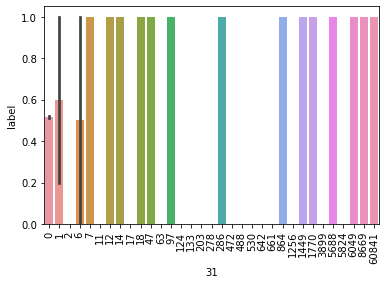

In [99]:
sns.barplot(x=train['31'],y=train['label'],ci=95) #95% confidence interval (the default)
plt.xticks(rotation=90);

* So, although most of the patients do not have microbe 31, there are several patients that show the presence of this microbe, and which also have this disease. 
* Below I define a helper function to plot microbe count distributions segregated by the target value. These type of plots are useful for understanding how the presence of microbe counts are related to the target variable

In [5]:
def segregatedPlot(df:pd.DataFrame,col:str,grouping:str='label'):
    '''conveniently making segregated plots'''
    sns.distplot(df.groupby(grouping)[col].get_group(0).dropna(),kde=False,rug=False, label=grouping.capitalize()+'=0');
    ax=sns.distplot(df.groupby(grouping)[col].get_group(1).dropna(),kde=False,rug=False, label=grouping.capitalize()+'=1');
    ax.set_yscale('log')
    plt.xlabel('Microbe '+col+' counts')
    plt.ylabel('Patients with count')
    plt.legend();

In [7]:
#making a list of the microbes in the dataset
microbes=train.columns.to_list()[1:-1]

* Below is an example of my segregated plots. Note that **by 'Patients with count' I mean how many patients show the given microbe count**

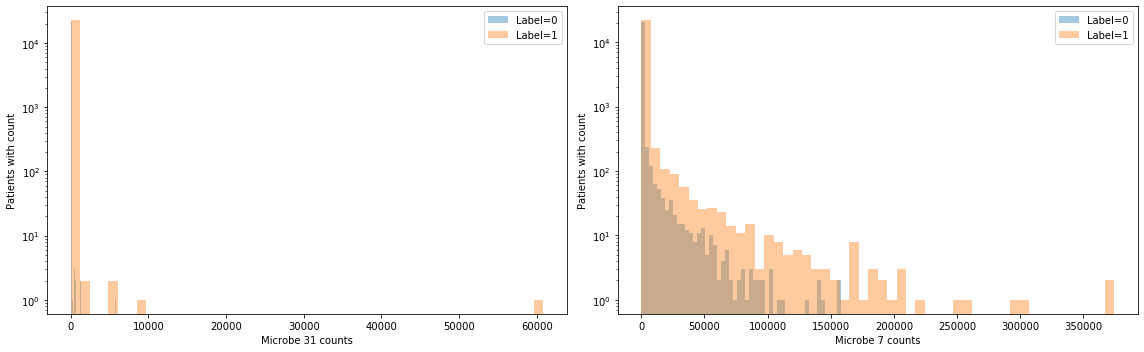

In [6]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
segregatedPlot(train,microbes[31])
plt.subplot(1,2,2)
segregatedPlot(train,microbes[7])       
plt.tight_layout();           

* As I noted above, a few patients with large counts of microbe 31 are positive (label 1). 
* In the plot at the right, again most patients don't show the presence of microbe 7, but there are many patients -in the 100's- which show larger counts of 7, and are positive
* I would use these types of plots to find out which microbes are better markers of the disease, and to guide the construction of a classification model
* Below I show the code that I would use to **make plots for all microbes**:

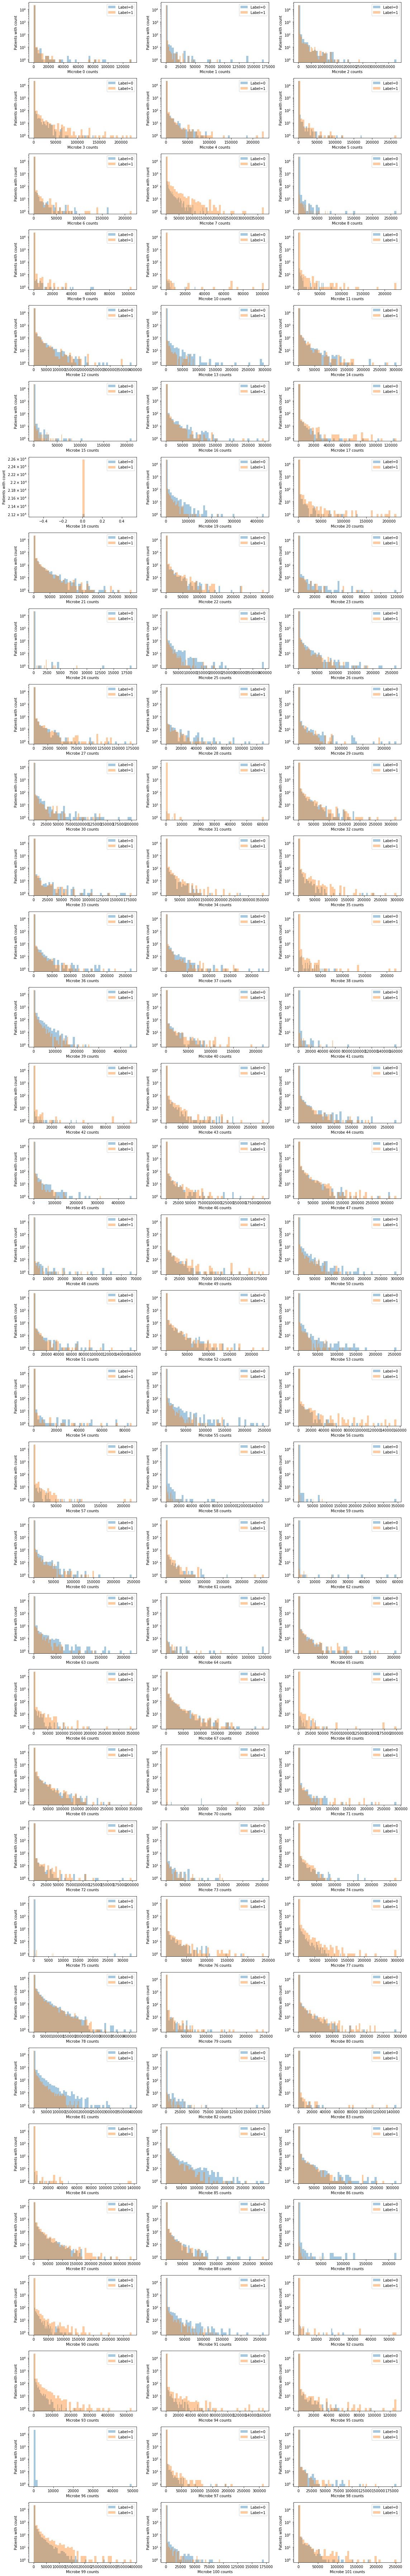

In [116]:
batch=102
batch_count=0
plt.figure(figsize=(16,100))
j=1
for i in range(batch_count*batch,(batch_count+1)*batch):
    plt.subplot(34, 3, j)
    j+=1
    segregatedPlot(train,microbes[i])
plt.tight_layout();     
batch_count+=1

* Below I calculate and try to plot a correlation map for the microbial activity

In [8]:
logTrain=np.log10(train[microbes].replace(0,-1))
#logTrain.replace(np.NINF,-1)
print(logTrain.shape)
logTrain.head()

(43769, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.60206,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.477121,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.009663,NaN


In [11]:
logTrain=pd.concat([logTrain,train.label],axis=1)
logTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.60206,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,1.477121,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.009663,NaN,1


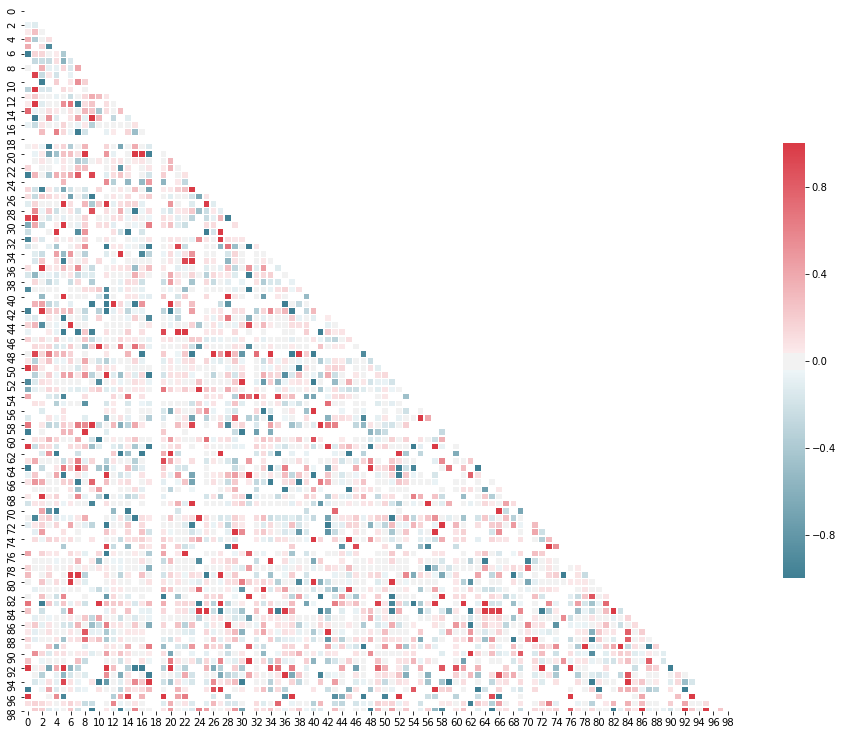

In [16]:
#corr = logTrain.corr()
plt.figure(figsize=(16,16))
#diverging colormap
#cmap = sns.diverging_palette(220,10,as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr.iloc[0:100,0:100], dtype=np.bool)
#triu_indices_from() returns the indices for the upper-triangle of arr
mask[np.triu_indices_from(mask)] = True 

sns.heatmap(corr.iloc[0:100,0:100], mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});